## Script for Projection Catalog
### Setup

In [89]:
import numpy as np
import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from tools.setup.setup import home_dir

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()

import healpy as hp
import fitsio
from tools.setup.setup import tools_home_dir
import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy import cosmology
from astropy.cosmology import WMAP9 as cosmo #WMAP9 cosmology
from astropy.coordinates import Distance

from tools.setup.setup import bigdata_home_dir, data_home_dir, home_dir
import astropy.io.fits as fits

# setup notebook for inline figures
%matplotlib inline

#file containing the rotation matrix 
toolsdir = tools_home_dir()
rotfile = toolsdir+'desy3_irot.pkl'
with open(rotfile, 'r') as fp:
    rmat = pickle.load(fp)
    
import pkg_resources
pkg_resources.get_distribution("astropy").version

bigdatadir = bigdata_home_dir()
datadir = data_home_dir()
homedir = home_dir()

### Projection catalog
#### Add X,Y,Z columns into the projection catalog

The Cartesian (X,Y,Z) are in units of Mpc/h when converting from spherical using the SkyCoord function and distance taken from comving_distane. h0 is given by user under e.g. WMAP9 cosmology. 

Buzzard halos coordinates are in units of Mpc, not Mpc/h.

This step NOT needed as we are matching using RA, DEC, Z coordinates. Oh wait, for the shape catalog we still need the X,Y,Z. Still need to convert from Z to distance using some cosmology. How do we do that and make it consistent?

In [90]:
proj_dir = bigdatadir + 'Buzzard_Sims/v1.6/projection/'+'mock_SDSS_PlM_logNorm_lM_Simet_lobg5.fit'
proj_list = fits.open(proj_dir)
proj_data = proj_list[1].data


#Convert RA, DEC to Cartesian coordinates
h0 = cosmo.H(0).value/100.#Reduced Hubble constant

proj_dist = cosmo.comoving_distance(proj_data.Z_TR) #In units of Mpc/h
c = SkyCoord(ra=proj_data.RA*u.degree, dec=proj_data.DEC*u.degree, distance=proj_dist, frame='icrs')
proj_X = c.cartesian.x.value #in units of Mpc/h
proj_Y = c.cartesian.y.value
proj_Z = c.cartesian.z.value

#Add X,Y,Z
c1 = fits.Column(name='proj_X', array=proj_X, format='E') #E is single float precision, D for double. 
c2 = fits.Column(name='proj_Y', array=proj_Y, format='E')
c3 = fits.Column(name='proj_Z', array=proj_Z, format='E')
newcols = [c for c in proj_list[1].columns] + [c1, c2, c3]
tnew = fits.BinTableHDU.from_columns(newcols)
proj_list[1] = tnew


#Extract data
proj_data = proj_list[1].data
#Checking FITS into
#hrun_list.info()
print "Names of columns in proj_data are:"
print proj_data.names


#Converting FITS files into record array
proj_data = np.array(proj_data, dtype=proj_data.dtype)
proj_data = proj_data.view(np.recarray)

print "Number of halos is", len(proj_data)

#proj_list.writeto('projection.fits')
#print "Wrote FITS with added columns onto new FITS file."

Names of columns in proj_data are:
['M200', 'Z_TR', 'Z_OB', 'RA', 'DEC', 'LAMBDA_TR', 'LAMBDA_OB', 'proj_X', 'proj_Y', 'proj_Z']
Number of halos is 668152


### redM_matched Halos

In [91]:
#RedM_matched halos
#Read from redM_matched halos
homedir = home_dir()
redM_dir = homedir + 'output/buzzard/'+'halo_redM_matched.dat'

#Field names of the files from first row of file. Shoule be:
#('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', 'halos_ID', 'halos_RA', 'halos_DEC', 
#'halos_z', 'halos_X', 'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir')
redM_halos = np.genfromtxt(redM_dir, dtype ="i, f8, f8, f8, f8, i, f8, f8, f8, f8, f8, f8, f8, f8, f8", \
                  unpack=True, usecols=range(0,15), names=True)
redM_halos = redM_halos.view(np.recarray)

redM_dist = cosmo.comoving_distance(redM_halos.halos_z)

print "Names of redM_matched halo column data are:"
print redM_halos.dtype.names, "\n"
print "Number of halos read is ", len(redM_halos)

Names of redM_matched halo column data are:
('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', 'halos_ID', 'halos_RA', 'halos_DEC', 'halos_z', 'halos_X', 'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir') 

Number of halos read is  23998


### Matching Projection Catalog with Chinchilla halos
* Note: astropy.comoving in units of Mpc/h 

#### Checking consistency of parameters in catalogs

In [92]:
#Sort halos by mass, and see if the most massive ones have matching properties. 
proj_sortind = np.argsort(proj_data.M200)
proj_indmax = proj_sortind[-1]
print proj_sortind
print proj_data.M200[proj_sortind]
print '\nTesting properties of largest halo in Projection Catalog'
print proj_data.dtype.names
print proj_data[proj_indmax]

#For the Chinchilla catalog. 
print '\nTesting the Chinchilla catalog'
redM_sortind = np.argsort(redM_halos.halos_M200b)
redM_indmax = redM_sortind[-1]
print redM_halos.dtype.names
redM_maxM = redM_halos[redM_indmax]
print redM_maxM

print proj_data[proj_indmax].proj_X*h0, proj_data[proj_indmax].proj_Y*h0, proj_data[proj_indmax].proj_Z*h0, '\n'
print proj_dist[proj_indmax] *h0
#Find comoving distance of Chinchilla and cf. with Pythagoreous
print redM_dist[redM_indmax] *h0
#print np.sqrt(redM_maxM.PX**2. + redM_maxM.PY**2. +  redM_maxM.PZ**2.)

[134241  79679 109881 ...  50468 278906 220279]
[1.0013e+13 1.0013e+13 1.0013e+13 ... 2.3066e+15 2.5839e+15 3.3991e+15]

Testing properties of largest halo in Projection Catalog
('M200', 'Z_TR', 'Z_OB', 'RA', 'DEC', 'LAMBDA_TR', 'LAMBDA_OB', 'proj_X', 'proj_Y', 'proj_Z')
(3.3991e+15, 0.38548893, 0.37671077, 148.0982, 59.208557, 279.9802, 396.04456, -661.15247, 411.56, 1306.8656)

Testing the Chinchilla catalog
('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', 'halos_ID', 'halos_RA', 'halos_DEC', 'halos_z', 'halos_X', 'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir')
(25, 328.8614288, -55.6656258, 0.3902748, 247.1500558, 115444861, 328.8543058, -55.6614458, 0.3898808, 514.4646928, -310.9048198, -879.9248528, 3.403e+15, 3.2463e+15, 3.3968578)
-458.3108893066406 285.29339030761713 905.9192343261718 

1054.57612507 Mpc
1065.40138633 Mpc


### Matched Catalog for testing
Use topcat for matching RA, DEC, Z

datadir = data_home_dir()
homedir = home_dir()
proj_dir = datadir + 'projection/'+'proj_buzzmatched_test.fits'
proj_list = fits.open(proj_dir)
proj_data = proj_list[1].data
print proj_data.names
print "Number of halos is ", len(proj_data)
proj_data = proj_data.view(np.recarray)

#### Old code for proximity matching with the astropy package

### Testing the matched catalogs

#Seeing the offset in distance, redshift after catalog matching
f, ax = plt.subplots(1, 2, figsize=(6,3), tight_layout=True)
f.suptitle('Offset comparison')
M_line = np.linspace(1e13,5e15,100)
z_line = np.linspace(0,1,100)
ax[0].scatter(proj_data.M200_2, proj_data.M200B, s=1)
ax[0].plot(M_line, M_line, linestyle='dashed', c='orange')
ax[0].set_xlabel(r'M200$_{2}$ $(M_{\odot})$')
ax[0].set_ylabel(r'M200B $(M_{\odot})$')
ax[1].scatter(proj_data.Z, proj_data.Z_TR, s=1)
ax[1].plot(z_line, z_line, linestyle='dashed', c='orange')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$\textrm{z}_{Tr}$')
plt.show()

#### Original coordinates of the projection catalog UN-rotated. Plot shows after rotation

#Rotate the halo files
import healpy as hp
import fitsio
from tools.setup.setup import tools_home_dir
import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord

#file containing the rotation matrix 
toolsdir = tools_home_dir()
rotfile = toolsdir+'desy3_irot.pkl'
with open(rotfile, 'r') as fp:
    rmat = pickle.load(fp)
    
halos_posvec = np.array([proj_data.HALOPX, proj_data.HALOPY, proj_data.HALOPZ])
halos_rposvec = np.dot(rmat, halos_posvec)

#Rotate the Cartesian positions.
proj_X = halos_rposvec[0]; proj_Y = halos_rposvec[1]; proj_Z = halos_rposvec[2]
#convert to angular coords (in Radians)
theta, phi = hp.vec2ang(proj_rposvec.T)
proj_DEC = (np.pi/2 - theta) * 180/np.pi
proj_RA  = phi * 180/np.pi

from astropy.cosmology import WMAP9 as cosmo

sparse_ind = rand.choice(len(proj_data), 50000, replace=False)
proj_data = proj_data[sparse_ind]

#h-scaling
h0 = cosmo.H(0).value/100

#Compare the comoving distances and see if one has a h-scaling
proj_comv = cosmo.comoving_distance(proj_data.Z_TR).value *h0
proj_dist = np.sqrt(proj_data.HALOPX**2. + proj_data.HALOPY**2. + proj_data.HALOPZ**2.)
print proj_dist
test_comv = cosmo.comoving_distance(0.90).value
print test_comv//25
print max(proj_dist)//25
print max(proj_data.Z_TR)

comv_line = np.linspace(0,2000,1000)
plt.figure(figsize=(4,3))
plt.scatter(proj_comv, proj_dist, s=0.1)
plt.plot(comv_line, comv_line, linestyle='--', c='orange')
plt.show()

## Import the matched catalog that's been vetted

In [93]:
datadir = data_home_dir()
homedir = home_dir()
proj_dir = bigdatadir + 'Buzzard_Sims/v1.6/projection/'+'proj_buzzmatched.fits'
proj_list = fits.open(proj_dir)
proj_data = proj_list[1].data
print proj_data.names
proj_data = proj_data.view(np.recarray)
print "Initially projection catalog has halo number ", len(proj_data)

['HALOID', 'M200', 'R200', 'M200B', 'R200B', 'M500', 'R500', 'MVIR', 'RVIR', 'M2500', 'R2500', 'VRMS', 'RS', 'JX', 'JY', 'JZ', 'SPIN', 'HALOPX', 'HALOPY', 'HALOPZ', 'HALOVX', 'HALOVY', 'HALOVZ', 'LUMTOT', 'LUM20', 'LBCG', 'RA', 'DEC', 'NGALS', 'N18', 'N19', 'N20', 'N21', 'N22', 'EDGE', 'HOST_HALOID', 'XOFF', 'VOFF', 'B_TO_A', 'C_TO_A', 'AX', 'AY', 'AZ', 'LAMBDA', 'VIRIAL_RATIO', 'Z_TR', 'Z_OB', 'LAMBDA_TR', 'LAMBDA_OB', 'Separation']
Initially projection catalog has halo number  668152


#### Applying cuts

* Mass cut M > 1e13
* $\lambda_{obs}$ > 5
* redshift cut at $z < 0.34$
* shape convergence cut
* sparse sampling

In [99]:
import numpy.random as rand
#Mass cut
mass_cut = np.where(proj_data['M200B'] >= 1e13)
proj_data = proj_data[mass_cut]
print "After mass cut projection catalog has halo number ", len(proj_data)

#Lambda cut
lmda_cut = np.where(proj_data['LAMBDA_OB'] >= 20)
proj_data = proj_data[lmda_cut]
print "After lmda cut projection catalog has halo number ", len(proj_data)

#Redshift cut
z_cut = np.where((proj_data['Z_TR']<0.9))
proj_data = proj_data[z_cut]
print "After redshift cut projection catalog has halo number ", len(proj_data)

'''
#shape convergence cut
conv_cut = np.where(proj_shape['converge'] == True)
proj_data = proj_data[conv_cut]
print "After conv cut projection catalog has halo number ", len(proj_data)
'''

'''
#Make into a sparse array
sparse_num = 20000
sparse_ind = rand.choice(len(proj_data), sparse_num, replace=False)
#sparse_ind = xrange(sparse_num)
proj_data = proj_data[sparse_ind]
print "After sparse sampling proj_data has length ", len(proj_data)
'''

print "Done"

After mass cut projection catalog has halo number  3762
After lmda cut projection catalog has halo number  3762
After redshift cut projection catalog has halo number  3762
Done


#### Save the file into halo_shape format

I think using rand.choice might change the order of different parameters so they are not paired up anymore. It turns out to be the case. See what's going on in the morning. 

#Retreive columns
proj_ID = proj_data['HALOID']; proj_RA = proj_data['RA'] 
proj_DEC = proj_data['DEC']; proj_z = proj_data['Z_TR']
proj_M200b = proj_data['M200B']; proj_Mvir = proj_data['MVIR']
proj_Rvir = proj_data['RVIR'] #in Mpc
proj_X = proj_data['HALOPX']; proj_Y = proj_data['HALOPY']; proj_Z = proj_data['HALOPZ']

#Write to file
name_str = ('halos_ID','halos_RA', 'halos_DEC', 'halos_z', 'halos_X', \
            'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir')

outfile = open(homedir +'/data/projection/proj_lowz.dat','w')
outfile.write('%12s %12s %12s %12s %12s %12s %12s %12s %12s %12s \n'%name_str)

for i in range(len(proj_data.HALOID)):
    outfile.write('%d %f8 %f8 %f8 %f8 %f8 %f8 %f8 %f8 %f8 \n' \
                  %(proj_ID[i], proj_RA[i], proj_DEC[i], proj_z[i], \
                        proj_X[i], proj_Y[i], proj_Z[i], proj_M200b[i], proj_Mvir[i], proj_Rvir[i]))
outfile.close()

## Adding parameters into the projection catalog
* Convert from (RA, DEC, Z) to (X, Y, Z)
* IDs from proximity matching to Chinchilla
* cos(i) shape information


In [105]:
from repo.halo_shape.read_shape_param import read_shape_param
from numpy.lib.recfunctions import append_fields

#Adding ID and shape info
shapedir = home_dir()+'output/projection/halo_shape/'
proj_shape = np.load(shapedir + 'halo_shape_projection_lowz.npy')

#Extract shape parameters 
halos_ID, q, s, cos_i = read_shape_param(proj_shape, convcut=False) #set convcut to false and apply cut later

#Match proj_data with shape using HALOID.
proj_ind = np.nonzero(np.in1d(proj_data.HALOID, halos_ID))[0]
proj_data = proj_data[proj_ind]
print  "After shape matching number of halos in the projection catalog is ", len(proj_data)
print "Number of halos not converged ", len(np.where(proj_shape['converge'] == False)[0])
print "Over {} number of total halos".format(len(proj_shape))

#Match proj_shape with proj_data
proj_ind = np.nonzero(np.in1d(halos_ID, proj_data.HALOID))[0]
cos_i = cos_i[proj_ind]
halos_ID = halos_ID[proj_ind]
print "Number of cosine is ", len(cos_i)
#proj_data = proj_data[proj_ind]

print halos_ID
print proj_data.HALOID

After shape matching number of halos in the projection catalog is  3762
Number of halos not converged  169
Over 20000 number of total halos
Number of cosine is  3762
[ 136583  136606  136667 ... 2329295 2329344 2329499]
[ 136583  136606  136667 ... 2329295 2329344 2329499]


In [106]:
#Need to re-run the proj_data reading before running this again
#proj_data = append_fields(proj_data, ['ID', 'q', 's', 'cosi'], [halos_ID, q, s, cos_i], usemask=False)
proj_data =  proj_data.view(np.recarray)
print proj_data.dtype

(numpy.record, [('HALOID', '>i8'), ('M200', '>f4'), ('R200', '>f4'), ('M200B', '>f4'), ('R200B', '>f4'), ('M500', '>f4'), ('R500', '>f4'), ('MVIR', '>f4'), ('RVIR', '>f4'), ('M2500', '>f4'), ('R2500', '>f4'), ('VRMS', '>f4'), ('RS', '>f4'), ('JX', '>f4'), ('JY', '>f4'), ('JZ', '>f4'), ('SPIN', '>f4'), ('HALOPX', '>f4'), ('HALOPY', '>f4'), ('HALOPZ', '>f4'), ('HALOVX', '>f4'), ('HALOVY', '>f4'), ('HALOVZ', '>f4'), ('LUMTOT', '>f4'), ('LUM20', '>f4'), ('LBCG', '>f4'), ('RA', '>f4'), ('DEC', '>f4'), ('NGALS', '>i4'), ('N18', '>i4'), ('N19', '>i4'), ('N20', '>i4'), ('N21', '>i4'), ('N22', '>i4'), ('EDGE', '>i2'), ('HOST_HALOID', '>i8'), ('XOFF', '>f4'), ('VOFF', '>f4'), ('B_TO_A', '>f4'), ('C_TO_A', '>f4'), ('AX', '>f4'), ('AY', '>f4'), ('AZ', '>f4'), ('LAMBDA', '>f4'), ('VIRIAL_RATIO', '>f4'), ('Z_TR', '>f4'), ('Z_OB', '>f4'), ('LAMBDA_TR', '>f4'), ('LAMBDA_OB', '>f4'), ('Separation', '>f8')])


#Save the projection data as a record array
outfile = outfile = homedir +'output/projection/proj_shapedata_lowz.npy'
np.save(outfile, proj_data)

## Tests


#### Check for orientation dependence of $\Delta\lambda$

In [107]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind = halo_bin_stat(cos_i, cosi_bins)

#Bin by richness observed
lmda_max = np.max(proj_data.LAMBDA_OB)
lmda_bins = [[20,30],[30,50],[50, np.inf]] #upper limit must match lower limit of next bin
lmda_num_bin = len(lmda_bins)
num_lmda_bins = len(lmda_bins)
lmda_bins_ind = halo_bin_stat(proj_data.LAMBDA_OB, lmda_bins)
lnM_lmda_binned = np.zeros_like(lmda_bins_ind)
lnM_lmda_binned = np.array([np.log(proj_data.M200B[lmda_bins_ind[x]]) for x in range(len(lmda_bins_ind))])

#print lnM_lmda_binned
print 'Maximum richness after cuts is ', lmda_max

Maximum richness after cuts is  234.0411


In [108]:
from scipy.stats import sem
from scipy.stats import binned_statistic as bin_stat
d_lmdafrac = (proj_data['LAMBDA_OB'] - proj_data['LAMBDA_TR'])/proj_data['LAMBDA_OB']

#Binned by lambda
x = np.linspace(0,1, cosi_num_bin)
y = np.empty((lmda_num_bin, cosi_num_bin)); yerr = np.empty((lmda_num_bin, cosi_num_bin))
for i, lmda_bin in enumerate(lmda_bins):
    #print lmda_bin
    for j, cosi_bin_ind in enumerate(cosi_bins_ind):
        lmda_ob_binned = proj_data.LAMBDA_OB[cosi_bin_ind]
        lmda_bin_ind = halo_bin_stat(lmda_ob_binned, [lmda_bin])
        lmda_ob_binned = lmda_ob_binned[lmda_bin_ind][0]
        d_lmdafrac_binned= d_lmdafrac[cosi_bin_ind]
        d_lmdafrac_binned = d_lmdafrac_binned[lmda_bin_ind][0]
        
        #lists are mutable 
        y[i,j] = np.mean(d_lmdafrac_binned)
        yerr[i,j] = np.std(d_lmdafrac_binned)     
        #print np.shape(d_lmdafrac_binned), np.mean(d_lmdafrac_binned), sem(d_lmdafrac_binned)
    #print '\n'

    
##Global trend, no binning by richness
#Error bars
nbins = 10
cosi_range = (0.0,1)
dlmda_range = (-1,1.1)
n, _ = np.histogram(cos_i, bins=nbins, range=cosi_range)
sy, _ = np.histogram(cos_i, bins=nbins, weights=d_lmdafrac, range=cosi_range)
sy2, cosi_bins = np.histogram(cos_i, bins=nbins, weights=d_lmdafrac**2., range=cosi_range)
dlmda_cosi_mean = sy / n
dlmda_cosi_std = np.sqrt(sy2/n - dlmda_cosi_mean**2.)

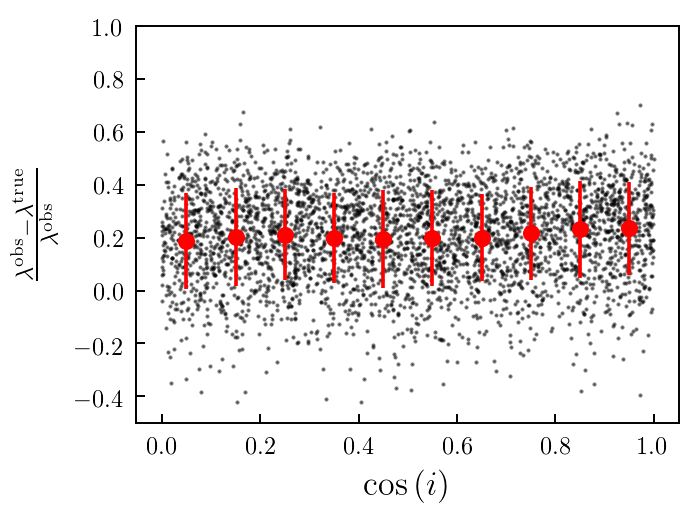

In [115]:
#Make it plot of the fractional lambda difference in different richness bins
fig, ax = plt.subplots(1,1, figsize = (4,3))
#Scatter plot
ax.scatter(cos_i, d_lmdafrac, s=0.5, alpha=0.5, color='black')
#Error bar plot
ax.errorbar((cosi_bins[1:] + cosi_bins[:-1])/2, dlmda_cosi_mean, yerr=dlmda_cosi_std, fmt='ro')

'''
for i, lmda_bin_ind in enumerate(lmda_bins_ind):
    ax.errorbar(x, y[i], yerr=yerr[i], \
                 label=r'$\lambda \in [{:.2f},{:.2f})$'.format(lmda_bins[i][0],lmda_bins[i][1]), \
                 marker='o', markersize=2, alpha=0.8, capsize=2)
'''

plt.xlabel(r'$\cos{(i)}$', fontsize=14)
plt.ylabel(r'$\frac{\lambda^{\rm obs} - \lambda^{\rm true}}{\lambda^{\rm obs}}$', fontsize=14)
#plt.title(r'$\Delta\lambda$ in $\cos{i}$ bins \newline in Projection catalog')
#plt.legend(loc='upper left', fontsize=9)
plt.ylim([-0.5,1])
plt.show()

#### Checking if halos are out of the filebin boundaries of the lightcones

#### Finding a specific halo

In [ ]:
"Element in nd array `a` closest to the scalar value `a0`"
def find_nearest(a, a0):
    a0 = np.array(a0)
    idx = np.empty(len(a0))
    for i in range(len(idx)):
        idx[i] = np.abs(a - a0[i]).argmin()
    return idx


#Open up the file and from nearest in RA,DEC find the halo index
proj_dir = homedir + 'data/projection/proj_allz.dat'
halos_ID, halos_RA, halos_DEC, halos_z, halos_X, halos_Y, halos_Z, halos_M200B, halos_Mvir, halos_Rvir \
        = np.loadtxt(proj_dir, dtype ="i, f, f, f, f, f, f, f, f, f", unpack=True, usecols=range(0,10), skiprows=1)

#Checked that the DEC of halos matches too. 
#DEC_bug = [5.314832, 32.36425, 8.469979, 27.166033, 35.252964, 10.443577, 0.42193112, 28.524832, 24.96024, 4.001432]
RA_bug = np.array([0.826730787754, 131.528915405, 8.21925354004, 9.20631217957, 158.795761108, 163.899871826, \
                  27.3393783569, 4.24623680115, 143.395095825, 164.901733398]) 
ind_bug = find_nearest(halos_RA, RA_bug).astype(int).tolist()
print ind_bug, type(ind_bug)
print proj_data.RA[ind_bug], proj_data.DEC[ind_bug], proj_data.Z_TR[ind_bug]
print max(proj_data.Z_TR)
#Run the program using that halo index first and see if it generates a bug
#If not run the whole program and wait. 

In [ ]:
x = np.linspace(0,len(proj_data.Z_TR), len(proj_data.Z_TR))
plt.figure(figsize=(4,3))
plt.hist(proj_data.Z_TR)
plt.show()

num_highz = float(len(np.where(proj_data.Z_TR >= 0.34)[0]))
num_lowz = float(len(np.where(proj_data.Z_TR < 0.34)[0]))
highz_frac = (num_highz)/(num_lowz + num_highz)
print highz_frac, num_highz, num_lowz

#### Checking sky footprint of halos

In [ ]:
#Rotate the halo files
import healpy as hp
import fitsio
from tools.setup.setup import tools_home_dir
import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord


#file containing the rotation matrix 
toolsdir = tools_home_dir()
rotfile = toolsdir+'desy3_irot.pkl'
with open(rotfile, 'r') as fp:
    rmat = pickle.load(fp)
    
proj_posvec = np.array([proj_X, proj_Y, proj_Z])
proj_rposvec = np.dot(rmat, proj_posvec)

#Rotate the Cartesian positions.
proj_X = proj_rposvec[0]; proj_Y = proj_rposvec[1]; proj_Z = proj_rposvec[2]
#convert to angular coords (in Radians)
theta, phi = hp.vec2ang(proj_rposvec.T)
proj_DEC_rot = (np.pi/2 - theta) * 180/np.pi
proj_RA_rot = phi * 180/np.pi

In [ ]:
plt.figure(figsize=(4,3))
plt.scatter(proj_RA_rot[ind_bug], proj_DEC_rot[ind_bug], s=5)
plt.scatter(proj_RA_rot, proj_DEC_rot, s=0.1, alpha=0.1)
plt.show()

#### cos(i) distribution across richness mass
make this into a color-density plot

In [ ]:
#On colomaps: https://plot.ly/matplotlib/colors-and-colormaps/
#Another good one: https://matplotlib.org/examples/pylab_examples/pcolor_demo.html
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import OrderedDict

viridis = cm.get_cmap('viridis', 256)
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(4,3))

cbin = cosi_bins_ind[4]
cb1 = plt.scatter(proj_data['M200B'][cbin], proj_data['LAMBDA_OB'][cbin], c = proj_data['cosi'][cbin], cmap = viridis, \
            s =0.1, label='Matteo Projection Catalog')
cbar = plt.colorbar(cb1, ax=axs)

cbar.set_label(r'$cos(i)$')

#plt.scatter(redM_halos['halos_M200b'], redM_halos['redM_lmda'], s =0.1, color='b', label='Buzzard redMaPPer matched')
plt.xscale('log'); plt.yscale('log')
plt.xlim([1e13,1e15])
plt.ylim([5,200])
plt.title(r'Projection Catalog, $N = {}$'.format(len(proj_data)))
#plt.legend()
plt.show()

'''
#y, x = np.mgrid[slice(-3, 3 + dy, dy), slice(-3, 3 + dx, dx)]

#Forget about this part for now. 
x = proj_data['M200']; y = proj_data['LAMBDA_OB']; z = proj_data['cosi']
plt.pcolor(x, y, z, cmap=viridis, vmin=0, vmax=1)
plt.title('pcolor')
# set the limits of the plot to the limits of the data
plt.axis([x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xscale('log'); plt.yscale('log')
plt.xlim([1e13,1e15])
plt.ylim([5,200])
plt.show()
'''
print "Done"

#### Shape information

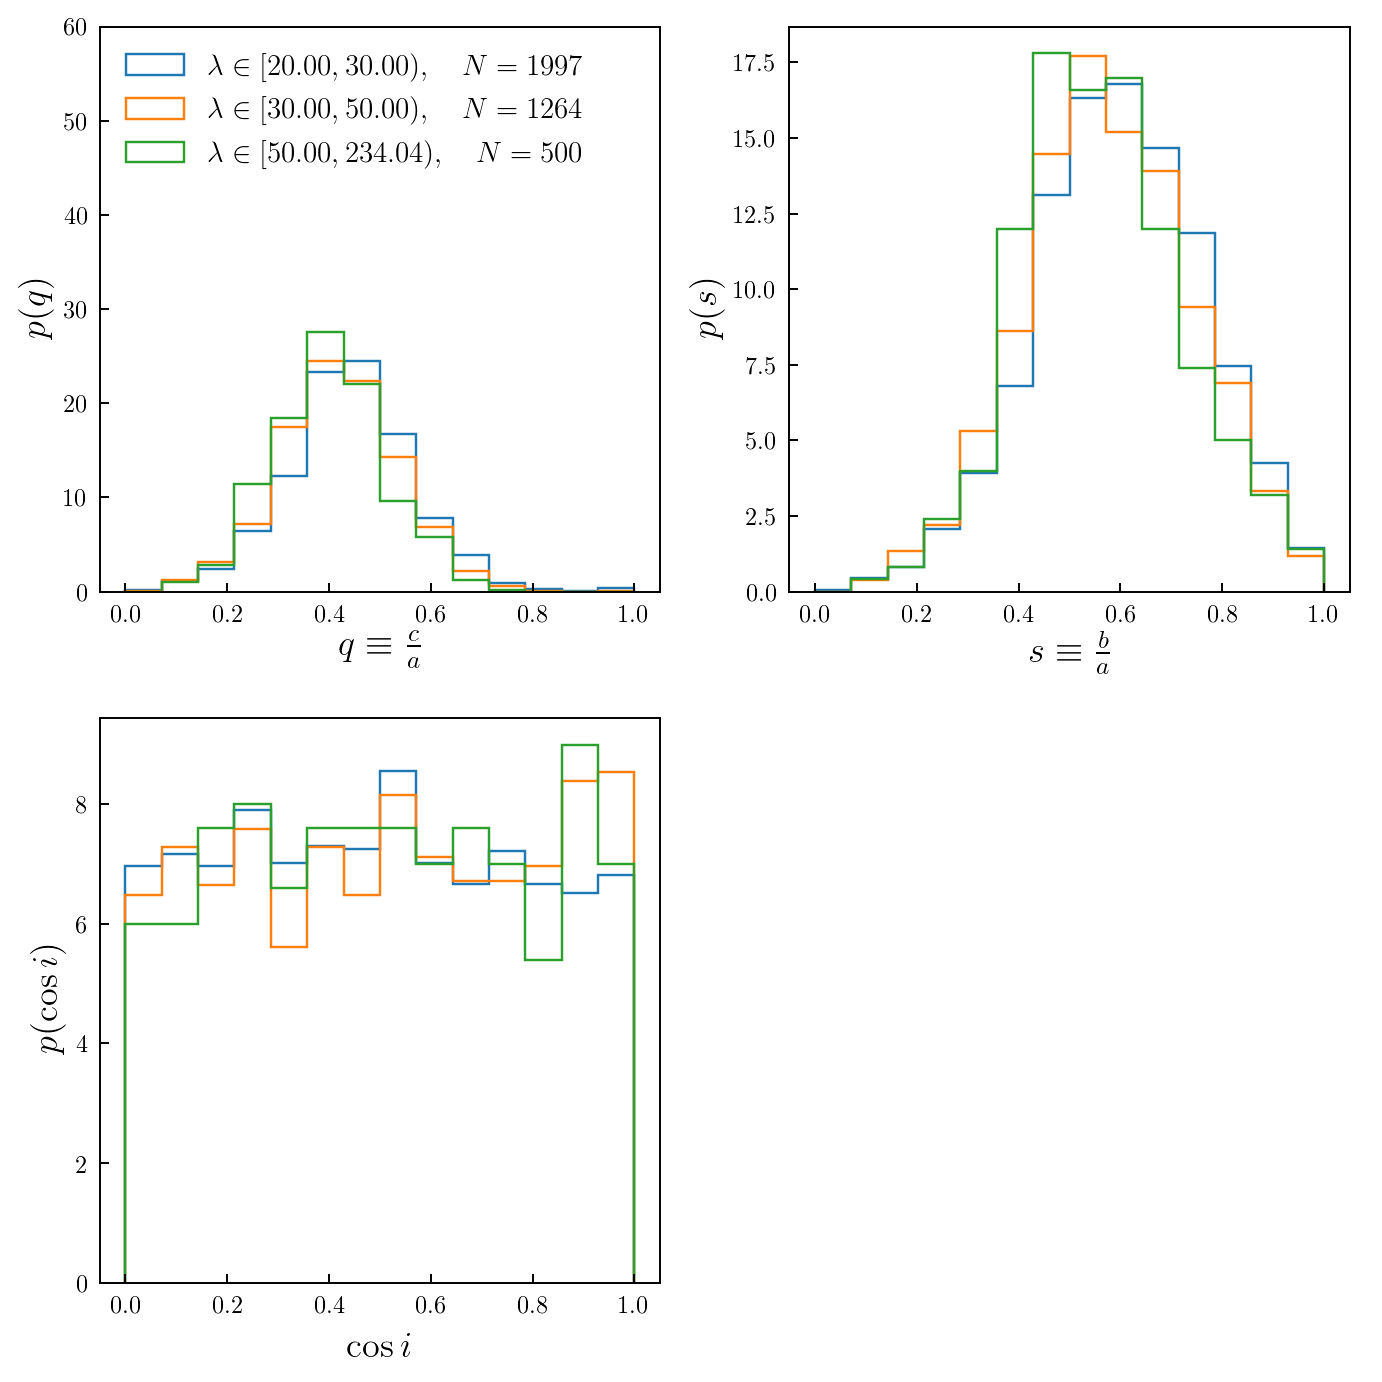

In [237]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(8,8))
num_bin = np.linspace(0.0,1.0,15)

#Plotting halo distribution
#Plotting redMaPPer selected by cos_i bins
for i, lmda_bin_ind in enumerate(lmda_bins_ind):   
    lmda_bin_num = len(lmda_bin_ind)
    lmda_bin_min = lmda_bins[i][0]; lmda_bin_max = lmda_bins[i][1]
    
    #Convert to probability in each bin
    weights = np.ones_like(q[lmda_bin_ind], dtype=float)/lmda_bin_num * 100
    #print weights
    axs[0,0].hist(q[lmda_bin_ind], num_bin, density=False, fill=False, weights=weights, histtype='step', \
               label=r'$\lambda \in [{:.2f}, {:.2f}),\quad N = {:d}$'.format(lmda_bin_min, lmda_bin_max, lmda_bin_num)) 

    axs[0,1].hist(s[lmda_bin_ind], num_bin, density=False, fill=False, weights=weights, histtype='step', \
               label=r'$\lambda \in [{:.2f}, {:.2f}), N = {:d}$'.format(lmda_bin_min, lmda_bin_max, lmda_bin_num)) 
    
    axs[1,0].hist(cos_i[lmda_bin_ind], num_bin, density=False, fill=False, weights=weights, histtype='step', \
               label=r'$\lambda \in [{:.2f}, {:.2f}), N = {:d}$'.format(lmda_bin_min, lmda_bin_max, lmda_bin_num)) 
    
axs[0,0].set_xlabel(r'$q \equiv \frac{c}{a}$', size=15)
axs[0,0].set_ylabel('$p(q)$', size=15)
#axs[0,0].set_title(r'Ellipticity: Minor to major axis ratio', fontsize=10)

axs[0,0].set_ylim((0,60))
axs[0,0].legend(loc='upper left', fontsize=12, frameon=False)

axs[0,1].set_xlabel(r'$s \equiv \frac{b}{a}$', size=15)
axs[0,1].set_ylabel('$p(s)$', size=15)
#axs[0,1].set_title(r'Ellipticity: Intermediate to major axis ratio', fontsize=10)    

axs[1,0].set_xlabel(r'$\cos{i}$', size=15)
axs[1,0].set_ylabel('$p(\cos{i})$', size=15)
axs[-1, -1].axis('off')
plt.show()
    

## Comparing hmf
* Buzzard v1.1
* Buzzard v1.3
* Halorun

Halorun and Buzzard v1.3 pdf should be the same as they use the same halos.

Run a Somolgorov test for hmf to check for consistency. 

#### Import Buzzard v1.1

In [254]:
buzzard_dir = datadir + 'buzzard_halo/chinchilla/' + 'Buzzard_v1.1_halos.fit'
buzz_list = fits.open(buzzard_dir)
buzz_data = buzz_list[1].data

#Checking FITS into
print "Names of columns in buzz_data are:"
print buzz_data.names

#Converting FITS files into record array
buzz_data = np.array(buzz_data, dtype=buzz_data.dtype)
buzz_v11_data = buzz_data.view(np.recarray)
#buzz_dist = cosmo.comoving_distance(buzz_data.Z)

print "\nNumber of halos is", len(buzz_v11_data)

Names of columns in buzz_data are:
['HALOID', 'M200', 'R200', 'M200B', 'R200B', 'M500', 'R500', 'MVIR', 'RVIR', 'M2500', 'R2500', 'VRMS', 'RS', 'JX', 'JY', 'JZ', 'SPIN', 'HALOPX', 'HALOPY', 'HALOPZ', 'HALOVX', 'HALOVY', 'HALOVZ', 'LUMTOT', 'LUM20', 'LBCG', 'RA', 'DEC', 'Z', 'NGALS', 'N18', 'N19', 'N20', 'N21', 'N22', 'EDGE', 'HOST_HALOID', 'XOFF', 'VOFF', 'LAMBDA', 'B_TO_A', 'C_TO_A', 'AX', 'AY', 'AZ', 'VIRIAL_RATIO']

Number of halos is 11212838


#### HMF from Buzzard v1.3 random halos

In [255]:
buzzard_dir = datadir + 'buzzard_halo/chinchilla/' + 'Chinchilla-0_halos_all.fits'
buzz_list = fits.open(buzzard_dir)
buzz_data = buzz_list[1].data

#Checking FITS into
print "Names of columns in buzz_data are:"
print buzz_data.names

#Converting FITS files into record array
buzz_data = np.array(buzz_data, dtype=buzz_data.dtype)
buzz_v13_data = buzz_data.view(np.recarray)
#buzz_dist = cosmo.comoving_distance(buzz_data.Z)

print "\nNumber of halos is", len(buzz_v13_data)

Names of columns in buzz_data are:
['ID', 'DESCID', 'MVIR', 'VMAX', 'VRMS', 'RVIR', 'RS', 'NP', 'PX', 'PY', 'PZ', 'VX', 'VY', 'VZ', 'JX', 'JY', 'JZ', 'SPIN', 'RS_KLYPIN', 'MVIR_ALL', 'M200B', 'M200C', 'M500C', 'M2500C', 'XOFF', 'VOFF', 'SPIN_BULLOCK', 'B_TO_A', 'C_TO_A', 'PID', 'LUMTOT', 'LUM20', 'LBCG', 'NGALS', 'N18', 'N19', 'N20', 'N21', 'N22', 'Z', 'RA', 'DEC']

Number of halos is 12198813


#### Halorun hmf

In [263]:
hrun_dir = datadir + 'halo_run/'+'buzzard-0_1.6_y3_run_halos_lambda_chisq_chto.fit'
hrun_list = fits.open(hrun_dir)
hrun_data = hrun_list[1].data

#Checking FITS into
#hrun_list.info()
print "Names of columns in hrun_data are: \n"
print hrun_data.names

#Converting FITS files into record array
hrun_data = np.array(hrun_data, dtype=hrun_data.dtype)
hrun_data = hrun_data.view(np.recarray)

print "\n Number of halos is", len(hrun_data)

Names of columns in hrun_data are: 

['HALOID', 'M200', 'R200', 'MEM_MATCH_ID', 'RA', 'DEC', 'Z', 'P_BCG', 'Z_LAMBDA', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_CHISQ_ZORIG', 'SCALEVAL', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'MASKFRAC', 'GEOMASKFRAC', 'R_LAMBDA', 'R_MASK', 'Z_LAMBDA_E', 'NCROSS', 'Z_LAMBDA_NITER', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'PZBINS', 'PZ', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'BCG_SPEC_Z', 'LIM_EXPTIME', 'LIM_LIMMAG_DERED', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD', 'ra_cent', 'dec_cent', 'p_cen', 'p_sat', 'ID_CENT']

 Number of halos is 124403


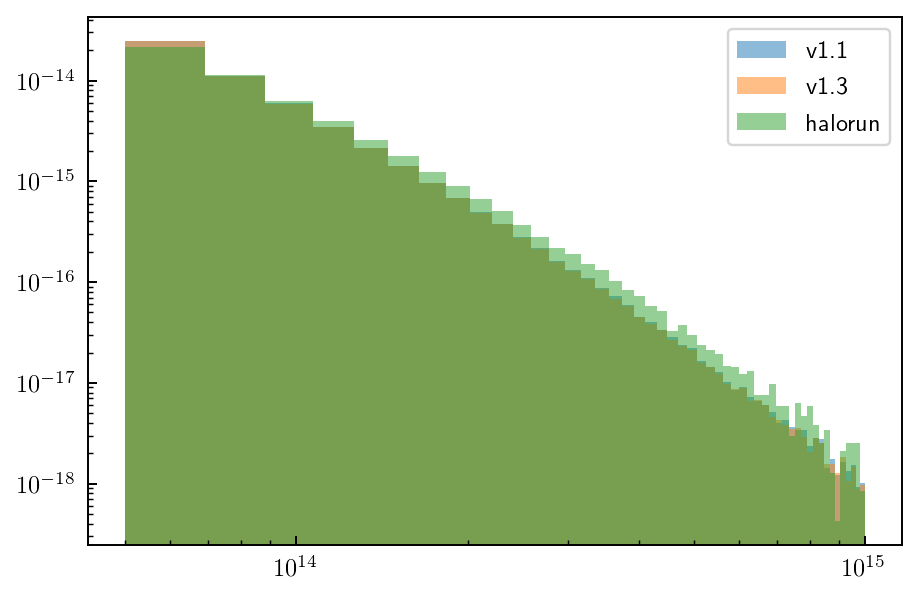

In [280]:
m_range = (5e13, 1e15)
mbins = 50
plt.hist(buzz_v11_data.M200B, mbins, m_range, label='v1.1', density=True, alpha=0.5)
plt.hist(buzz_v13_data.M200B, mbins, m_range, label='v1.3', density=True, alpha=0.5)
plt.hist(hrun_data.M200,      mbins, m_range, label='halorun', density=True, alpha=0.5)
plt.yscale('log'); plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [ ]:
#Apply Somolgorov test for consistency between distributions. 